# Análise Final La Msion Brasil

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [2]:
# Define que o pandas não deve limitar o número de colunas exibidas
pd.set_option("display.max_columns", None)

# BÔNUS: Você também pode fazer o mesmo para as linhas
pd.set_option("display.max_rows", None)

# BÔNUS: E aumentar a largura da exibição para evitar quebras de linha
pd.set_option("display.width", 1000)

## Carregando os dados

In [ ]:
df_completo = pd.read_csv("Dados/df_completo_final.csv", sep=",")
df_completo.head(10)

In [ ]:
df_completo.info()

In [ ]:
df_completo.describe()

## Análise Exploratória dos dados

Vamos começar analisando o desempenho geral dos atletas. Para isso devemos trasnformar nosso dataframe onde cada linha é um km do atleta, para um novo onde cada linha dever uma única observação do atleta e as variáveis vão ser um resumo.

In [ ]:
df_agregado_por_atleta = (
    df_completo.groupby("Nome Atleta")
    .agg(
        # Pega a informação demográfica (que é a mesma em todas as linhas do atleta)
        sexo=("sexo", "first"),
        faixa_etaria=("faixa_etaria", "first"),
        peso=("peso", "first"),
        ano_corrida=("ano", "first"),  # Pega o ano da corrida
        # Calcula as métricas de desempenho e estratégia
        Tempo_Final_seg=("tempo_por_km_seg", "sum"),
        Ritmo_Medio_seg=("tempo_por_km_seg", "mean"),
        Variabilidade_Ritmo_std=(
            "tempo_por_km_seg",
            "std",
        ),  # Desvio padrão do ritmo por km
        # Calcula as métricas de esforço relacionadas ao percurso
        Total_Desnivel_Positivo=("desnivel_positivo", "sum"),
        Total_Desnivel_negativo=("desnivel_negativo", "sum"),
    )
    .reset_index()
)

# Para facilitar a interpretação, vamos converter segundos para minutos
df_agregado_por_atleta["Tempo_Final_min"] = (
    df_agregado_por_atleta["Tempo_Final_seg"] / 60
)
df_agregado_por_atleta["Ritmo_Medio_min"] = (
    df_agregado_por_atleta["Ritmo_Medio_seg"] / 60
)
df_agregado_por_atleta["Variabilidade_Ritmo_min_std"] = (
    df_agregado_por_atleta["Variabilidade_Ritmo_std"] / 60
)

# Vamos ver como ficou
df_agregado_por_atleta.head()

### Análises gráficas

#### Dstribuição do tempo final

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.histplot(
    data=df_agregado_por_atleta,
    x="Tempo_Final_min",
    kde=True,
    bins=20,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribuição do Tempo Final dos Corredores")
axes[0].set_xlabel("Tempo Final (minutos)")  # Adicionando rótulo ao eixo x
axes[0].set_ylabel("Número de Atletas (Frequência)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)


sns.boxplot(
    data=df_agregado_por_atleta,
    y="Tempo_Final_min",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Distribuição do Tempo Final por Sexo")
axes[1].set_ylabel("Tempo Final (minutos)")
axes[1].grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

# Também é útil ver as estatísticas descritivas
print(df_agregado_por_atleta["Tempo_Final_min"].describe())

print("\n", df_agregado_por_atleta["Tempo_Final_min"].describe() / 60)

#### Análise do Sexo

In [ ]:
df_agregado_por_atleta["sexo"].value_counts()

- Aqui podemos observar a que a quantidade de participantes homens é maior que a participação de mulheres.

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

# Título principal para a figura inteira
fig.suptitle("Análise Comparativa do Tempo Final (minutos) por Sexo", fontsize=16)


# 2. Plote o histograma das Mulheres no primeiro eixo (axes[0])
sns.histplot(
    data=df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Mulheres"],
    x="Tempo_Final_min",
    bins=15,
    kde=True,
    ax=axes[0],
)  # A chave é especificar o eixo aqui!
axes[0].set_title("Distribuição para Mulheres")
axes[0].set_xlabel("Tempo Final (minutos)")
axes[0].set_ylabel("Frequência")


# 3. Plote o histograma dos Homens no segundo eixo (axes[1])
sns.histplot(
    data=df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Homens"],
    x="Tempo_Final_min",
    bins=15,
    kde=True,
    color="skyblue",  # Mudar a cor ajuda na diferenciação
    ax=axes[1],
)  # E aqui também!
axes[1].set_title("Distribuição para Homens")
axes[1].set_xlabel("Tempo Final (minutos)")
axes[1].set_ylabel("")  # Pode remover o label do eixo Y para um visual mais limpo


# 4. Exiba os gráficos
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajusta o layout para evitar sobreposição
plt.show()


# ======================================================================
# PARTE 2: ESTATÍSTICAS (.DESCRIBE()) LADO A LADO
# ======================================================================

# 1. Calcule o describe() para cada grupo separadamente
desc_mulheres = df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Mulheres"][
    "Tempo_Final_min"
].describe()
desc_homens = df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Homens"][
    "Tempo_Final_min"
].describe()


# 2. Use pd.concat para unir as duas saídas como colunas de um novo DataFrame
# axis=1 indica que a concatenação deve ser feita pelas colunas (lado a lado).
# keys=[] define os nomes das novas colunas.
estatisticas_comparativas = pd.concat(
    [desc_mulheres, desc_homens], axis=1, keys=["Mulheres", "Homens"]
)


# 3. Imprima a tabela comparativa final
print("--- Estatísticas Descritivas Comparativas ---")
print(
    estatisticas_comparativas.round(2)
)  # .round(2) para formatar com 2 casas decimais


In [ ]:
estatisticas_describe = ["count", "mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = (
    df_agregado_por_atleta.groupby("sexo")
    .agg(
        {
            "Tempo_Final_min": estatisticas_describe,
            "Ritmo_Medio_min": estatisticas_describe,
            "Variabilidade_Ritmo_min_std": estatisticas_describe,
        }
    )
    .stack(level=0)
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Sexo ---")
print(resumo_completo.round(2))

In [ ]:
# Sexo vs. Tempo Final
sns.boxplot(data=df_agregado_por_atleta, x="sexo", y="Tempo_Final_min")
plt.title("Tempo Final por Sexo")
plt.show()


1. Tempo Final da Prova (Tempo_Final_min)

Desempenho Médio: Os homens terminaram a prova, em média, cerca de 1 hora mais rápido que as mulheres (mean de 406 min para homens vs. 465 min para mulheres). A mediana (o valor do meio) confirma essa tendência, mostrando que o corredor "mediano" masculino também foi consideravelmente mais rápido.

Dispersão: A dispersão dos tempos é alta e relativamente parecida para ambos os grupos (std de 119 min para homens e 124 min para mulheres). Isso indica que, em ambos os sexos, havia uma grande variedade de níveis de habilidade, desde os corredores mais rápidos até os que levaram mais tempo. Podendo existir níveis entre os corredores, indo de corredores mais experientes e profissionais ate corredores amadores e menos experientes.

2. Ritmo Médio (Ritmo_Medio_min)

Velocidade Média: Confirmando o dado anterior, o ritmo médio dos homens foi mais baixo (mais rápido), com uma média de 11.36 min/km contra 13.07 min/km das mulheres.

Melhores e Piores Ritmos: O homem mais rápido teve um ritmo médio de 6.57 min/km, enquanto a mulher mais rápida teve um ritmo médio de 8.21 min/km. Ambos os grupos tiveram atletas com ritmos médios bem mais lentos (22.60 e 20.41 min/km), o que é comum em corridas de montanha devido à dificuldade do percurso.

3. Variabilidade do Ritmo (Variabilidade_Ritmo_min_std)

Consistência da Prova: Esta é talvez a métrica mais interessante. Em média, os homens tiveram uma menor variabilidade de ritmo dentro da sua prova (mean de 6.63) em comparação com as mulheres (mean de 7.98).

##### Teste de Hipótese - Comparando tempo entre Homens e Mulheres

#### Análise por Faixa etária

In [ ]:
df_agregado_por_atleta["faixa_etaria"].value_counts() / len(df_agregado_por_atleta)

- Aqui podemos notar uma grande concetração em corredores de 35 a 44 anos, seguindo de corredores mais jovens de 25 a 34 anos. Temos um acumo de 90% dos participantes indo de 25 a 55 anos.

In [ ]:
estatisticas_describe = ["count", "mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = (
    df_agregado_por_atleta.groupby("faixa_etaria")
    .agg(
        {
            "Tempo_Final_min": estatisticas_describe,
            "Ritmo_Medio_min": estatisticas_describe,
        }
    )
    .stack(level=0)
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Faixa Etaria---")
print(resumo_completo.round(2))

In [ ]:
# Faixa Etária vs. Tempo Final
plt.figure(figsize=(10, 6))  # Aumenta o tamanho da figura para caber as labels
# Remove None values before sorting to avoid TypeError
faixa_etaria_order = sorted(
    [x for x in df_agregado_por_atleta["faixa_etaria"].unique() if x is not None]
)
sns.boxplot(
    data=df_agregado_por_atleta,
    x="faixa_etaria",
    y="Tempo_Final_min",
    order=faixa_etaria_order,
)
plt.title("Tempo Final por Faixa Etária")
plt.xticks(rotation=45)  # Rotaciona as labels do eixo x para não sobrepor
plt.show()

- Tendência Geral: O gráfico evidencia uma tendência geral de aumento do tempo mediano de conclusão da prova com o avanço da idade. Contudo, essa relação não se mostra perfeitamente linear.

- Melhor Desempenho: A faixa etária de 20 a 24 anos se destaca com o menor tempo mediano e a menor dispersão (caixa mais compacta). Isso sugere que este grupo não só foi o mais rápido, em média, mas também o mais homogêneo em termos de performance.

- Maior Variabilidade: O grupo de 35 a 44 anos apresenta a maior amplitude interquartil (a "altura" da caixa), indicando a maior variabilidade nos tempos de conclusão. Isso pode sugerir que esta faixa contém uma mistura mais heterogênea de atletas, desde os muito experientes até os iniciantes.

- Ponto de Inflexão: Nota-se um ponto , que a cada mudança de faixa etaria, tem uma certa tendencia em aumentar a mediana no tempo total da prova.

- Outlier: É importante destacar a presença de um outlier no grupo de 20 a 24 anos, indicando um atleta com um tempo de prova atipicamente superior ao de seus pares na mesma faixa etária.

Comparando pelo tempo médio por km

In [ ]:
# Faixa Etária vs. Tempo Final
plt.figure(figsize=(10, 6))  # Aumenta o tamanho da figura para caber as labels
# Remove None values before sorting to avoid TypeError
faixa_etaria_order = sorted(
    [x for x in df_agregado_por_atleta["faixa_etaria"].unique() if x is not None]
)
sns.boxplot(
    data=df_agregado_por_atleta,
    x="faixa_etaria",
    y="Ritmo_Medio_min",
    order=faixa_etaria_order,
)
plt.title("Ritmo Médio por Faixa Etária")
plt.xticks(rotation=45)  # Rotaciona as labels do eixo x para não sobrepor
plt.show()

##### Teste de Hipótese - Comparando Tempo final por Faixa Etárias

#### Análise por faixa de peso

In [ ]:
df_agregado_por_atleta["peso"].value_counts()

In [ ]:
# Peso vs. Tempo Final
plt.figure(figsize=(10, 6))
# Remove None values before sorting to avoid TypeError
peso_order = sorted(
    [x for x in df_agregado_por_atleta["peso"].unique() if x is not None]
)
sns.boxplot(
    data=df_agregado_por_atleta, x="peso", y="Tempo_Final_min", order=peso_order
)
plt.title("Tempo Final por Faixa de Peso")
plt.xticks(rotation=45)
plt.show()

- Tendência Principal: Fica clara a correlação entre o aumento da faixa de peso e o aumento no tempo mediano de prova. Atletas mais leves tenderam a ser mais rápidos.

- Desempenho nos Extremos: O grupo de 54 kg e abaixo obteve os melhores tempos, enquanto a faixa de 95 a 104 kg registrou o desempenho médio mais lento.

- Variabilidade: As faixas de peso intermediárias (55 a 74 kg) mostram a maior dispersão nos resultado, indicando uma grande variação de performance nesses grupos.

- Dados não informados: O grupo "Não informado" apresenta um desempenho mediano, posicionando-se de forma similar às categorias de peso intermediárias.

##### Teste de Hipótese - Comparando Tempo final por Classes de Peso

#### Análise da Variabilidade de Ritmo

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.histplot(
    data=df_agregado_por_atleta,
    x="Variabilidade_Ritmo_min_std",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribuição da Variabilidade do Ritmo (Desvio Padrão em min/km)")
axes[0].set_ylabel("Número de Atletas (Frequência)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_agregado_por_atleta,
    x="Variabilidade_Ritmo_min_std",
    y="Tempo_Final_min",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Variabilidade do Ritmo")
axes[1].set_xlabel("Variabilidade do Ritmo (Desvio Padrão em min/km)")
axes[1].set_ylabel("Tempo Final Total (minutos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

- Correlação Positiva Evidente: O gráfico mostra uma clara e forte correlação positiva entre as duas variáveis. Isso significa que, à medida que a variabilidade do ritmo aumenta (eixo X), o tempo final da prova também tende a aumentar (eixo Y).

- Interpretação Prática: Em termos simples, os atletas que mantiveram um ritmo mais constante e com menos oscilações foram, em geral, os que terminaram a prova mais rápido. A consistência no ritmo parece ser um indicador chave para um bom desempenho.

- Comparativo entre Sexos: Ambos os grupos, homens e mulheres, seguem a mesma tendência linear. Não há uma separação clara dos grupos, indicando que essa relação entre consistência e performance é válida para ambos. No entanto, é possível notar que os pontos com o melhor desempenho combinado (canto inferior esquerdo, com baixo tempo e baixa variabilidade) são, em sua maioria, de atletas masculinos.

- Conclusão: A consistência do ritmo é um fator crucial para o desempenho nesta prova. Atletas menos eficientes em manter um passo estável, provavelmente devido ao terreno ou à estratégia, acabaram com tempos de conclusão significativamente mais altos.

In [ ]:
df_agregado_por_atleta[df_agregado_por_atleta["Variabilidade_Ritmo_min_std"] > 16]

In [ ]:
df_filtro_atleta = df_completo.loc[
    df_completo["Nome Atleta"] == "Evelyn Carboneiro",
    ["Nome Atleta", "tempo_por_km_seg", "desnivel_positivo", "desnivel_negativo"],
]
df_filtro_atleta["Minutos"] = df_filtro_atleta["tempo_por_km_seg"] / 60
df_filtro_atleta

In [ ]:
df_coef_var = df_agregado_por_atleta.copy()
df_coef_var["coef_var"] = (
    df_coef_var["Variabilidade_Ritmo_min_std"] / df_coef_var["Ritmo_Medio_min"]
)
df_coef_var.head()

In [ ]:
df_coef_var.loc[
    df_coef_var["Nome Atleta"] == "Evelyn Carboneiro",
    [
        "Nome Atleta",
        "Tempo_Final_min",
        "Ritmo_Medio_min",
        "Variabilidade_Ritmo_min_std",
        "coef_var",
    ],
]

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.histplot(
    data=df_coef_var,
    x="coef_var",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribuição do Coef. Variação do Ritmo")
axes[0].set_ylabel("Número de Atletas (Frequência)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_coef_var,
    x="coef_var",
    y="Tempo_Final_min",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Coef. Variação do Ritmo")
axes[1].set_xlabel("Coef. Variação do Ritmo")
axes[1].set_ylabel("Tempo Final Total (minutos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
sns.scatterplot(
    data=df_coef_var,
    y="coef_var",
    x="Variabilidade_Ritmo_min_std",
    hue="sexo",  # Direciona o plot para o segundo eixo
)
plt.title("Tempo Final vs. Coef. Variação do Ritmo")
plt.ylabel("Coef. Variação do Ritmo")
plt.xlabel("Tempo Final Total (minutos)")
plt.grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

### Analisando Partes da Prova

Vamos analisar o tempo médio entre primeira metade e segunda metade da prova.

- (Split Positivo): Significa que o ritmo na segunda metade foi mais alto (mais lento)
- (Split Negativo): Seria o caso de um atleta que correu a segunda metade mais rápido que a primeira.

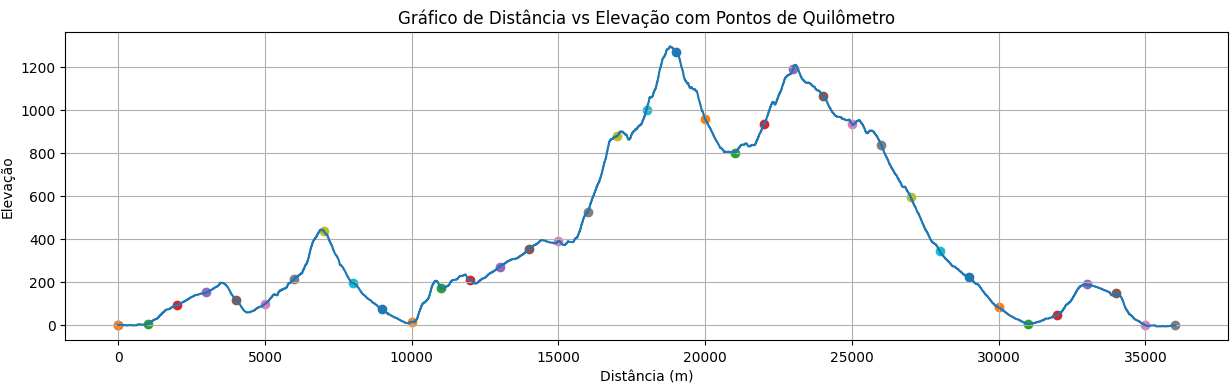

In [ ]:
df_metade = df_completo.copy()
df_metade["Metade_Prova"] = "Primeira Metade"
df_metade.loc[df_metade["km_prova"] > 18.0, "Metade_Prova"] = "Segunda Metade"
df_metade.head(5)

In [ ]:
df_kms = (
    df_metade[["km_prova", "desnivel_positivo", "desnivel_negativo", "Metade_Prova"]]
    .drop_duplicates()
    .reset_index(drop=True)
)
df_kms.head()

In [ ]:
estatisticas_describe = ["sum", "mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = (
    df_kms.groupby("Metade_Prova")
    .agg(
        {
            "desnivel_positivo": estatisticas_describe,
            "desnivel_negativo": estatisticas_describe,
        }
    )
    .stack(level=0)
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Parte da Prova ---")
print(resumo_completo.round(2))

Primeira Metade: A Fase de "Conquista"
Ganho de Elevação Total (sum): Você sobe 1768 metros.

Perfil Predominante: É majoritariamente subida. O ganho de elevação (+1768m) é mais que o dobro da perda (-767m).

Dificuldade Média (mean/median): Um quilômetro típico tem uma subida brutal. A média de ganho é de 98.2m por km, e a mediana é de 73.5m, indicando subidas constantes e íngremes.

Pico de Dificuldade (max): Existe pelo menos um quilômetro com 354 metros de subida, uma verdadeira "parede".

Segunda Metade: A Fase de "Descida e Velocidade"
Perda de Elevação Total (sum): Você desce -2023 metros.

Perfil Predominante: É majoritariamente descida. A perda de elevação (-2023m) é o dobro do ganho (+1019m).

Dificuldade Média (mean/median): Um quilômetro típico é quase plano. A mediana de ganho de apenas 9.5m revela que a maioria dos quilômetros tem pouca ou nenhuma subida, permitindo um ritmo muito mais rápido.

Pico de Dificuldade (max): Ainda existem subidas duras (máximo de 299m), mas são mais pontuais e menos frequentes que na primeira metade.

Resumo Comparativo Final
Balanço (Subida vs. Descida):

Primeira Metade: Saldo positivo de +1001 metros (muito mais sobe do que desce).

Segunda Metade: Saldo negativo de -1004 metros (muito mais desce do que sobe).

Esses números provam que a estratégia correta é ser extremamente conservador no início, pois a maior parte do esforço de subida está concentrada na primeira metade, enquanto a segunda metade oferece um terreno muito mais favorável para correr.

In [ ]:
sns.boxplot(data=df_metade, x="Metade_Prova", y="tempo_por_km_seg")
plt.title("Tempo Final por Parte da Prova")
plt.show()

In [ ]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = (
    df_metade.groupby("Metade_Prova")
    .agg({"tempo_por_km_seg": estatisticas_describe})
    .stack(level=0)
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Parte da Prova ---")
print(resumo_completo.round(2))

- Primeira Metade (Com mais subidas):

Ritmo mais lento e variado: A grande quantidade de subidas força os atletas a desacelerar, o que explica os tempos mais altos e a maior variação de performance.

Quilômetros mais difíceis: Os tempos extremamente lentos (outliers) confirmam que as subidas mais brutais estão nesta parte.

- Segunda Metade (Com menos subidas):

Ritmo mais rápido e consistente: Com um terreno mais favorável, os atletas conseguem impor um ritmo mais forte e constante.

Prova de perfil assimétrico: O gráfico não mostra que os atletas estão menos cansados, mas sim que a maior dificuldade da prova está concentrada no início.

In [ ]:
ritmo_por_metade = df_metade.groupby(["Nome Atleta", "Metade_Prova"]).agg(
    tempo_por_km_seg=("tempo_por_km_seg", "mean"),
    tempo_total=("tempo_por_km_seg", "sum"),
)
comparativo_splits = ritmo_por_metade.unstack()
multi_level_columns = comparativo_splits.columns
novos_nomes_colunas = [
    f"Ritmo_Medio_{metade.replace(' ', '_')}"
    if metrica == "tempo_por_km_seg"
    else f"Tempo_Total_{metade.replace(' ', '_')}"
    for metrica, metade in multi_level_columns
]

# 3. Atribua os novos nomes ao seu DataFrame
comparativo_splits_flat = comparativo_splits.copy()  # Copia para não alterar o original
comparativo_splits_flat.columns = novos_nomes_colunas

colunas_em_segundos = [
    "Ritmo_Medio_Primeira_Metade",
    "Ritmo_Medio_Segunda_Metade",
    "Tempo_Total_Primeira_Metade",
    "Tempo_Total_Segunda_Metade",
]
for coluna in colunas_em_segundos:
    # 3. Defina o nome da nova coluna, adicionando '_min' ao final
    nova_coluna_min = coluna + "_min"

    # 4. Crie a nova coluna, fazendo a conversão (dividir por 60) e arredondando (round(2))
    comparativo_splits_flat[nova_coluna_min] = (
        comparativo_splits_flat[coluna] / 60
    ).round(2)


comparativo_splits_flat["Diferenca_Media_Seg_Menos_Pri"] = (
    comparativo_splits_flat["Ritmo_Medio_Segunda_Metade_min"]
    - comparativo_splits_flat["Ritmo_Medio_Primeira_Metade_min"]
).round(2)
comparativo_splits_flat["Diferenca_total_Seg_Menos_Pri"] = (
    comparativo_splits_flat["Tempo_Total_Segunda_Metade_min"]
    - comparativo_splits_flat["Tempo_Total_Primeira_Metade_min"]
).round(2)
comparativo_splits_flat.head(5)

In [ ]:
# Vamos unir as duas tabelas
df_final_completo = pd.merge(
    left=df_agregado_por_atleta,  # A tabela principal, da esquerda
    right=comparativo_splits_flat,  # A tabela com os splits, da direita
    left_on="Nome Atleta",  # A chave na tabela da esquerda é a COLUNA 'Nome Atleta'
    right_index=True,  # A chave na tabela da direita é o ÍNDICE (que também é o nome do atleta)
    how="left",  # 'how=left' garante que todos os atletas da tabela principal sejam mantidos
)

df_final_completo.head()
df_final_completo.to_csv("Dados/df_agregado_por_atleta.csv", sep=";")

In [ ]:
df_final_completo.head(3)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(
    data=df_final_completo,
    x="Tempo_Total_Primeira_Metade",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribuição do Tempo de prova na 1ª Metade")
axes[0].set_ylabel("Número de Atletas (Frequência)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_final_completo,
    x="Ritmo_Medio_Primeira_Metade",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Ritmo médio 1ª Metade")
axes[1].set_xlabel("Ritmo médio 1ª Metade (seg/km)")
axes[1].set_ylabel("Tempo Final Total (segundos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(
    data=df_final_completo,
    x="Tempo_Total_Segunda_Metade",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribuição do Tempo de prova na 2ª Metade")
axes[0].set_xlabel("Tempo na 2ª Metade (segundos)")  # Adicionando rótulo ao eixo x
axes[0].set_ylabel("Número de Atletas (Frequência)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)


sns.scatterplot(
    data=df_final_completo,
    x="Ritmo_Medio_Segunda_Metade",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Ritmo médio 2ª Metade")
axes[1].set_xlabel("Ritmo médio 2ª Metade (seg/km)")
axes[1].set_ylabel("Tempo Final Total (segundos)")
axes[1].grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

- **Gráfico da 1ª Metade (Subidas)**: Os pontos parecem formar uma linha mais coesa e estreita. A relação parece muito forte e direta. A dispersão dos pontos em torno de uma linha de tendência imaginária é relativamente pequena.

- **Gráfico da 2ª Metade (Descidas)**: Os pontos ainda seguem uma tendência linear, mas parecem estar um pouco mais espalhados. A "nuvem" de pontos é um pouco mais larga.

Após estabelecermos a dinâmica de 'split negativo' da prova, onde a segunda metade é consistentemente mais rápida devido à sua altimetria favorável, uma nova questão emerge: 

> **Qual dos dois segmentos da corrida é mais decisivo para o resultado final de um atleta?**

Em outras palavras, o desempenho na primeira metade, marcada pelas subidas e pelo maior desgaste, é um indicador mais forte do tempo final? Ou a performance na segunda metade, que exige técnica e a capacidade de capitalizar nas descidas, tem uma influência maior? A análise a seguir busca quantificar a força da relação entre o ritmo de cada metade e o tempo total de prova para determinar qual fase é mais preditiva do sucesso.

-  O "Porquê" por Trás da Hipótese
Isso faz total sentido no contexto de uma prova de montanha:

*A 1ª Metade (subidas) funciona como um "filtro" de condicionamento físico. Um atleta que não tem um bom preparo físico registrará um tempo muito alto aqui, e será praticamente impossível compensar essa diferença, não importa quão bem ele desça. O desempenho nesta fase estabelece uma "base" sólida para o tempo final.*

*A 2ª Metade (descidas) introduz outras variáveis, como habilidade técnica, coragem para arriscar e o nível de fadiga acumulado. Um atleta pode ser muito forte na subida, mas um descensor cauteloso, ou vice-versa. Isso cria uma variabilidade maior, enfraquecendo ligeiramente a correlação direta com o tempo final.*

**Vamos fazer a correlação de Pearson para medir essa relação e depois comparar se há diferença significativa entre os valores**

In [ ]:
correlacoes = df_final_completo[
    ["Tempo_Final_seg", "Ritmo_Medio_Primeira_Metade", "Ritmo_Medio_Segunda_Metade"]
].corr()

print(correlacoes)

- A análise mostra que tanto o ritmo na primeira metade quanto na segunda são preditores excepcionalmente fortes do tempo final, com correlações quase perfeitas. Embora a primeira metade tenha uma correlação marginalmente maior, a diferença é tão trivial que não é estatisticamente significativa. Para todos os efeitos práticos, você pode concluir que o desempenho em ambas as metades da prova é igualmente crucial e determinante para o resultado final do atleta.

- **Ponto de Atenção**: Existe uma correlação alta entre duas varáiveis que podem vir a ser usadas numa futura modelagem.

In [ ]:
plt.figure(figsize=(8, 4))
sns.scatterplot(
    data=df_final_completo,
    x="Ritmo_Medio_Primeira_Metade",
    y="Ritmo_Medio_Segunda_Metade",
    hue="sexo",
)
plt.title("Ritmo médio 2ª Metade vs. Ritmo médio 1ª Metade")
plt.ylabel("Ritmo médio 2ª Metade (seg/km)")
plt.xlabel("Ritmo médio 1ª Metade (seg/km)")
plt.grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

##### Análise do ritmo médio por parte da prova

In [ ]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = df_final_completo.groupby("sexo").agg(
    {
        "Ritmo_Medio_Primeira_Metade": estatisticas_describe,
        "Ritmo_Medio_Segunda_Metade": estatisticas_describe,
    },
    future_stack=True,
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Partes da prova e sexo ---")
print(resumo_completo.round(2))

In [ ]:
df_melted = pd.melt(
    df_final_completo,
    id_vars=["sexo"],
    value_vars=["Ritmo_Medio_Primeira_Metade", "Ritmo_Medio_Segunda_Metade"],
    var_name="Metade da Prova",
    value_name="Ritmo Médio (min/km)",
)

# Opcional: Renomear os valores para ficarem mais bonitos no gráfico
df_melted["Metade da Prova"] = df_melted["Metade da Prova"].replace(
    {
        "Ritmo_Medio_Primeira_Metade": "1ª Metade",
        "Ritmo_Medio_Segunda_Metade": "2ª Metade",
    }
)


# --- Passo 3: Criar o gráfico boxplot ---
plt.style.use("seaborn-v0_8-whitegrid")  # Estilo do gráfico
plt.figure(figsize=(8, 4))  # Tamanho do gráfico

sns.boxplot(
    data=df_melted,
    x="Metade da Prova",
    y="Ritmo Médio (min/km)",
    hue="sexo",
    palette={"Homens": "skyblue", "Mulheres": "salmon"},  # Cores personalizadas
)

# Adicionando Títulos e Rótulos
plt.title("Distribuição do Ritmo por Metade da Prova e Sexo", fontsize=16, pad=20)
plt.xlabel("")  # Eixo X não precisa de rótulo
plt.ylabel("Ritmo Médio (min/km)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Sexo", fontsize=11)


# Exibir o gráfico
plt.show()

**Análise da 1ª Metade (Subidas):**

- Desempenho Médio: A mediana do ritmo dos homens (linha no meio da caixa azul, ~680 seg/km ou 11:20 min/km) é visivelmente mais baixa (mais rápida) que a das mulheres (~820 seg/km ou 13:40 min/km). Isso indica que, como esperado, o atleta homem mediano foi mais rápido na seção de subida.

- Variabilidade: A caixa azul (Homens) é mais "curta" que a caixa vermelha (Mulheres). Isso significa que a performance do grupo masculino foi mais homogênea; a diferença de ritmo entre os 25% mais rápidos e os 25% mais lentos do "miolo" do grupo é menor. O desempenho das mulheres foi mais heterogêneo, com uma maior dispersão de ritmos.

- Outlier: Existe um atleta homem que foi um outlier, com um ritmo significativamente mais lento que seus pares na primeira metade.

**Análise da 2ª Metade (Descidas):**
- Desempenho Médio: A diferença se mantém. A mediana dos homens (~580 seg/km ou 9:40 min/km) continua mais rápida que a das mulheres (~730 seg/km ou 12:10 min/km).

- Melhora de Performance: É nítido que ambos os grupos foram muito mais rápidos na segunda metade. Todas as caixas da direita estão posicionadas mais abaixo no gráfico do que as da esquerda, confirmando visualmente o forte "split negativo" para todos.

- Variabilidade: A variabilidade para ambos os grupos continua alta, como é comum em trechos de descida que envolvem diferentes níveis de técnica e disposição ao risco. A performance masculina ainda parece um pouco mais concentrada que a feminina.

**Resumo das Conclusões**
- Desempenho Absoluto: Em termos de ritmo absoluto, os homens foram, em média, mais rápidos que as mulheres tanto na seção de subida (1ª metade) quanto na de descida (2ª metade).

- Consistência do Grupo: O grupo masculino apresentou uma performance mais consistente e homogênea na primeira metade da prova, com menor variação de ritmo entre seus atletas em comparação ao grupo feminino.

- Impacto do Percurso: O gráfico confirma de forma inequívoca que o perfil do percurso (subidas e depois descidas) foi o fator dominante na estratégia de ritmo, forçando todos os atletas, independentemente do sexo, a serem significativamente mais rápidos na segunda metade.

- Dinâmica Universal: Embora os homens sejam em média mais rápidos, a dinâmica geral da prova — um início mais lento e um final muito mais rápido — é uma característica universal para ambos os sexos.

##### Analise **Tempo de Prova** x **Diferença** entre primeira e segunda parte da prova.

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(
    data=df_final_completo, x="Diferenca_Media_Seg_Menos_Pri", kde=True, bins=15
)

# Adiciona uma linha vertical em x=0 para ser nossa referência
# À esquerda da linha: atletas que aceleraram (split negativo)
# À direita da linha: atletas que desaceleraram (split positivo)
plt.axvline(x=0, color="red", linestyle="--", linewidth=2)

plt.title("Distribuição da Diferença de Ritmo (2ª Metade vs. 1ª Metade)")
plt.xlabel("Diferença de Ritmo em Minutos (Positivo = Desacelerou)")
plt.ylabel("Número de Atletas (Frequência)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

A análise da distribuição da diferença de ritmo entre a primeira e a segunda metade da prova (gráfico de histograma) revelou um insight fundamental sobre a natureza da competição. Observou-se que a grande maioria dos atletas concluintes apresentou um "split negativo", ou seja, um ritmo médio mais rápido na segunda metade do percurso.

Este padrão, evidenciado pelo pico da distribuição em valores negativos (-2 a -3 min/km), não deve ser interpretado primariamente como uma escolha estratégica deliberada dos atletas. A causa raiz mais provável é o perfil altimétrico do percurso, com uma concentração de subidas e maior dificuldade na primeira metade.

Dessa forma, a variável Diferenca_Seg_Menos_Pri transcende a simples noção de estratégia e se torna um índice de gestão de prova e de eficiência do atleta. Ela quantifica a capacidade de cada indivíduo de administrar seu esforço na seção mais exigente para, então, capitalizar no trecho teoricamente mais favorável. Uma diferença mais negativa pode indicar uma gestão de energia superior. Portanto, esta variável é considerada relevante e será incorporada em análises subsequentes para investigar sua correlação com o desempenho geral e outras métricas dos atletas.

In [ ]:
sns.scatterplot(
    data=df_final_completo,
    x="Diferenca_Media_Seg_Menos_Pri",
    y="Tempo_Final_min",
    hue="sexo",
)
plt.title("Tempo Final vs. Administração do Tempo")
plt.xlabel("Administração do Tempo (Mais Negativo Melhor)")
plt.ylabel("Tempo Final (minutos)")
plt.show()

A variável "Administração do Tempo" não tem uma correlação linear simples com o tempo final, mas ela atua como um fator qualificador ou limitante para o alto desempenho.

- Necessário, mas não Suficiente: Para conseguir um tempo final de elite nesta prova, é necessário que o atleta execute a prova dentro de uma faixa ótima de gestão de ritmo (neste caso, entre -4 e -1 min/km de diferença). Estar nessa faixa não garante um bom tempo (você ainda precisa ser um atleta rápido), mas estar fora dela praticamente garantiza que você não terá um tempo de elite.

- Indicador de Quebra: Valores muito negativos (<-5) ou positivos (>0) não são indicativos de uma "estratégia diferente", mas sim de uma provável quebra de ritmo. O atleta com split de -7 provavelmente caminhou muito na primeira metade (gastando tempo) e por isso teve uma grande margem para "acelerar" na segunda. O atleta com split positivo provavelmente se esgotou completamente nas subidas e não conseguiu se recuperar.

#### Criando fator de "Quebra"

- Vimos que a Diferenca_Seg_Menos_Pri é útil, mas uma queda de 60 segundos no ritmo é muito mais significativa para um atleta de elite (que corre a 300 seg/km) do que para um iniciante (que corre a 900 seg/km). Normalizar essa diferença pelo ritmo do próprio atleta nos dá uma medida relativa do cansaço.

In [ ]:
df_final_completo["diff_relativa_segunda_primeira_parte"] = (
    (
        df_final_completo["Ritmo_Medio_Segunda_Metade"]
        - df_final_completo["Ritmo_Medio_Primeira_Metade"]
    )
    / df_final_completo["Ritmo_Medio_Primeira_Metade"]
).round(2)
df_final_completo.head()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(
    data=df_final_completo,
    x="diff_relativa_segunda_primeira_parte",
    kde=True,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title(
    "Distribuição do Diferença Relativa entre Segunda x Primeira Parte da Prova"
)
axes[0].set_xlabel("Diferença Relativa")  # Adicionando rótulo ao eixo x
axes[0].set_ylabel("Número de Atletas (Frequência)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)


sns.boxplot(
    data=df_final_completo,
    x="sexo",
    y="diff_relativa_segunda_primeira_parte",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Diferença Relativa entre Segunda x Primeira Parte da Prova por Sexo")
axes[1].set_ylabel("Diferença Relativa")
axes[1].grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

In [ ]:
df_final_completo["diff_relativa_segunda_primeira_parte"].describe().round(2)

**É notável que a grande maioria dos atletas (mais de 75%) conseguiu correr a segunda metade mais rápido.**

In [ ]:
sns.scatterplot(
    data=df_final_completo,
    x="diff_relativa_segunda_primeira_parte",
    y="Tempo_Final_min",
    hue="sexo",
)
plt.title("Tempo Final vs. Administração do Tempo")
plt.xlabel("Administração do Tempo (Mais Negativo Melhor)")
plt.ylabel("Tempo Final (minutos)")
plt.show()

O perfil da prova, com a primeira metade focada em subidas e a segunda em descidas, é o fator que define o desempenho.

- Regra da Prova: Acelerar na segunda metade não é uma estratégia, é uma consequência do percurso. Em média, os atletas foram 17% mais rápidos na segunda metade (média de -0.17), como mostra a distribuição normal no histograma.

- Fator de Sucesso: O gráfico de dispersão confirma que os atletas com os melhores tempos finais foram aqueles que mais conseguiram capitalizar nas descidas da segunda metade, ou seja, tiveram o índice mais negativo.

In [ ]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = df_final_completo.groupby("sexo").agg(
    {
        "diff_relativa_segunda_primeira_parte": estatisticas_describe,
    },
    future_stack=True,
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Fator Quebra ---")
print(resumo_completo.round(2))

Mesmo compondo apenas 30% da amostra, os dados das mulheres mostram um desempenho relativo superior na dinâmica da prova.

Desempenho Médio: As mulheres foram, em média, mais eficientes na segunda parte da prova. O índice delas foi de -0.21 (-21%), consideravelmente mais negativo que o dos homens, de -0.15 (-15%).

- Consistência: Os homens apresentaram os maiores casos de "quebra", com alguns chegando a ser 10% mais lentos na segunda parte da prova. As mulheres foram mais consistentes, com a maior queda de ritmo sendo de apenas 5%.

- Conclusão Direta: A prova exige a habilidade de subir na primeira metade e descer bem na segunda. A análise sugere que, embora os homens representem 70% dos dados, as mulheres, como grupo, foram relativamente mais eficientes em converter a segunda parte da prova em um ganho de velocidade percentual em relação à sua performance na primeira parte da prova.

**Conclusão**: A prova exige a habilidade de subir na primeira metade e descer bem na segunda. A análise sugere que, embora os homens representem 70% dos dados, as mulheres, como grupo, foram relativamente mais eficientes em converter a seção de descida em um ganho de velocidade percentual em relação à sua performance na subida.

#### Análise Inclinação da Prova

##### Análise Subida vs Descida

In [ ]:
df_sobe_desc = df_completo.copy()
df_sobe_desc["Diff_Sob_Desc"] = (
    df_sobe_desc["desnivel_positivo"] + df_sobe_desc["desnivel_negativo"]
)
df_sobe_desc["percent_inclin_subida"] = df_sobe_desc["desnivel_positivo"] / 1000 * 100
df_sobe_desc["percent_inclin_descida"] = df_sobe_desc["desnivel_negativo"] / 1000 * 100
df_sobe_desc["perc_diff"] = (
    df_sobe_desc["desnivel_positivo"] / abs(df_sobe_desc["desnivel_negativo"]) - 1
)
df_sobe_desc.head()

In [ ]:
def Sob_Desc(diff, desnivel_positivo_km, desnivel_negativo_km):
    if desnivel_positivo_km < 20 and desnivel_negativo_km > -20:
        return "PLANO"
    elif diff >= -0.5 and diff <= 0.5:
        return "MISTO"
    elif diff < -0.5:
        return "DESCIDA"
    else:
        return "SUBIDA"


# Aplicando a função ao DataFrame
df_sobe_desc["Sob_Desc"] = df_sobe_desc[
    ["perc_diff", "desnivel_positivo", "desnivel_negativo"]
].apply(lambda x: Sob_Desc(x[0], x[1], x[2]), axis=1)
df_sobe_desc.head(10)

In [ ]:
sns.boxplot(
    data=df_sobe_desc[df_sobe_desc["tempo_por_km_seg"] > 180],
    x="Sob_Desc",
    y="tempo_por_km_seg",
)
plt.title("Tempo Final por Tipo de Trecho")
plt.show()

In [ ]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = (
    df_sobe_desc[df_sobe_desc["tempo_por_km_seg"] > 180]
    .groupby("Sob_Desc")
    .agg(
        {
            "tempo_por_km_seg": estatisticas_describe,
        }
    )
    .stack(level=0)
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Tipo Inclinação ---")
print(resumo_completo.round(2))

- PLANO

Ritmo mais rápido de todos os trechos.

Maior consistência: Quase todos os atletas correm em um ritmo parecido.

- SUBIDA

Ritmo mais lento de forma disparada.

Maior variação de performance: É o trecho que mais diferencia os atletas. Onde a prova é "ganha" ou "perdida".

- MISTO

Ritmo intermediário, mais rápido que as subidas.

Quebra de ritmo: Terreno ondulado que exige variação constante de esforço.

- DESCIDA

Ritmo mais rápido que subidas, mas mais lento que o plano.

Exige técnica: A variação nos tempos mostra que a dificuldade do terreno e a habilidade do atleta são cruciais.

In [ ]:
categorias_desejadas = ["SUBIDA", "DESCIDA"]
df_filtrado = df_sobe_desc[
    (df_sobe_desc["Sob_Desc"].isin(categorias_desejadas))
    & (df_sobe_desc["tempo_por_km_seg"] > 180)
]

# 2. Criar o gráfico
plt.figure(figsize=(8, 4))  # Ajustei o tamanho para melhor visualização
sns.boxplot(
    data=df_filtrado,
    x="Sob_Desc",  # No eixo X, as categorias 'SUBIDA' e 'DESCIDA'
    y="tempo_por_km_seg",  # No eixo Y, o ritmo
    hue="sexo",  # O 'hue' separa os dados por sexo
)

# Adicionar títulos e formatação
plt.title("Comparativo de Ritmo em Subidas e Descidas por Sexo", fontsize=16)
plt.xlabel("Tipo de Trecho", fontsize=12)
plt.ylabel("Ritmo (segundos por km)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = df_filtrado.groupby(["sexo", "Sob_Desc"]).agg(
    {
        "tempo_por_km_seg": estatisticas_describe,
    },
    future_stack=True,
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Subida/Descida e sexo ---")
print(resumo_completo.round(2))

**Desempenho Absoluto**: Homens são Mais Rápidos em Ambos os Terrenos

- Tanto na **média** (*mean*) quanto na **mediana** (*median*), os homens apresentam um ritmo (tempo por km) inferior ao das mulheres.

- Na **Subida**: A mediana dos homens foi de 628 seg/km (~10:28 min/km), enquanto a das mulheres foi de 697 seg/km (~11:37 min/km).

- Na **Descida**: A mediana dos homens foi de 487 seg/km (~8:07 min/km), enquanto a das mulheres foi de 537 seg/km (~8:57 min/km).

- **Conclusão**: Em velocidade pura, os homens lideram em ambos os tipos de terreno.

**Variabilidade e Outliers**

- O gráfico mostra uma quantidade enorme de outliers (pontos circulares), especialmente nas subidas. Isso é típico em corridas de montanha, onde trechos específicos podem causar uma grande variação de ritmo (caminhada, dificuldades técnicas, etc.).

- A variabilidade, medida pelo desvio padrão (std), é muito alta para todos os grupos, mas ligeiramente maior para as mulheres, tanto na subida quanto na descida, indicando um grupo com desempenho um pouco mais heterogêneo.

**Conclusão: A Diferença Crucial entre Desempenho Absoluto e Relativo**
A análise do ritmo absoluto, que compara diretamente os segundos por quilômetro, estabelece um fato claro: os homens, como grupo, foram em média mais rápidos que as mulheres tanto nos trechos de subida quanto nos de descida. No entanto, essa visão não conta a história completa da performance e da estratégia na prova.

Para entender a dinâmica de como cada grupo aproveitou os diferentes terrenos, precisamos revisitar a análise de desempenho relativo, que foi o ponto de partida de nosso estudo quando comparamos a *primeira* e a *segunda* metade da prova. Naquela análise inicial, havíamos identificado que as mulheres apresentavam uma melhora percentual de ritmo mais significativa, um insight que agora podemos confirmar com os dados mais precisos de subida e descida.

Para quantificar essa "eficiência na transição" do terreno desfavorável para o favorável, calculamos a melhora relativa no ritmo de cada grupo usando a seguinte fórmula:

> $$ \text{Índice de Aceleração } (\%) = \left( \frac{\text{Ritmo Médio na Descida} - \text{Ritmo Médio na Subida}}{\text{Ritmo Médio na Subida}} \right) \times 100 $$

Aplicando os valores médios que encontramos, os resultados revelam uma nuance fundamental no desempenho:

>> Melhora Relativa dos Homens: (573.13 - 831.87) / 831.87 = -31.1%

>> Melhora Relativa das Mulheres: (639.78 - 965.91) / 965.91 = -33.8%

- Esses números confirmam que, embora não sejam mais rápidas em termos absolutos, as mulheres, como grupo, capitalizaram nas descidas de forma mais eficaz em relação ao seu próprio ritmo de subida. A aceleração relativa delas foi superior à dos homens.

Portanto, a conclusão final é dupla: enquanto os homens foram dominantes em velocidade pura, a análise relativa expõe que as mulheres demonstraram uma maior capacidade de maximizar seu ganho de velocidade nos trechos de descida, validando o padrão que havíamos observado inicialmente e adicionando uma camada mais profunda de entendimento sobre as diferentes estratégias de performance entre os sexos nesta prova.

##### Indice Diferença relativa entre Subida e Descida no Tempo médio

In [ ]:
df_sobe_desc.head(3)

In [ ]:
ritmo_por_nivel = df_sobe_desc.groupby(["Nome Atleta", "Sob_Desc"]).agg(
    tempo_por_km_seg=("tempo_por_km_seg", "mean"),
    tempo_total=("tempo_por_km_seg", "sum"),
)

# --- PASSO 2: Pivotar a tabela (unstack) ---
# Isso transforma as linhas de 'Sob_Desc' (PLANO, SUBIDA, etc.) em colunas.
# .fillna(0) é importante para atletas que talvez não tenham passado por um tipo de terreno.
comparativo_niveis = ritmo_por_nivel.unstack().fillna(0)


# --- PASSO 3: Achatar e renomear as colunas (mesma lógica de antes) ---
multi_level_columns_nivel = comparativo_niveis.columns
# Adaptamos a lógica para os níveis de inclinação
novos_nomes_colunas_nivel = [
    f"Ritmo_Medio_{nivel}" if metrica == "tempo_por_km_seg" else f"Tempo_Total_{nivel}"
    for metrica, nivel in multi_level_columns_nivel
]
comparativo_niveis.columns = novos_nomes_colunas_nivel


# --- PASSO 4: Converter as novas colunas de segundos para minutos ---
# A lista de colunas é gerada dinamicamente
colunas_em_segundos_nivel = novos_nomes_colunas_nivel

for coluna in colunas_em_segundos_nivel:
    nova_coluna_min = coluna + "_min"
    comparativo_niveis[nova_coluna_min] = (comparativo_niveis[coluna] / 60).round(2)

comparativo_niveis = comparativo_niveis.reset_index()

Juntando as tabelas

In [ ]:
df_final_completo.head(1)

In [ ]:
df_final_nivel_inclinacao = pd.merge(
    left=df_final_completo,
    right=comparativo_niveis,
    on="Nome Atleta",
    how="left",
)

# Exibindo o resultado final
print("Tabela final com a análise por nível de inclinação:")
df_final_nivel_inclinacao.head(5)

Criando Indice que compara:
- *Tempo Médio Subida* x *Tempo Médio Descida*
- *Tempo Médio Subida* x *Tempo Médio Total Prova*
- *Tempo Médio Descida* x *Tempo Médio Total Prova*

In [ ]:
df_final_nivel_inclinacao["indice_subida"] = (
    df_final_nivel_inclinacao["Ritmo_Medio_SUBIDA"]
    - df_final_nivel_inclinacao["Ritmo_Medio_seg"]
) / df_final_nivel_inclinacao["Ritmo_Medio_seg"]
df_final_nivel_inclinacao["indice_descida"] = (
    df_final_nivel_inclinacao["Ritmo_Medio_DESCIDA"]
    - df_final_nivel_inclinacao["Ritmo_Medio_seg"]
) / df_final_nivel_inclinacao["Ritmo_Medio_seg"]
df_final_nivel_inclinacao["indice_descida_vs_subida"] = (
    df_final_nivel_inclinacao["Ritmo_Medio_DESCIDA"]
    - df_final_nivel_inclinacao["Ritmo_Medio_SUBIDA"]
) / df_final_nivel_inclinacao["Ritmo_Medio_SUBIDA"]

df_final_nivel_inclinacao.head(5)

##### Indice do Ritmo Subida vs Ritmo médio Geral da prova

O índice criado`(Ritmo Subida - Ritmo Geral) / Ritmo Geral` é uma ótima forma de medir a **especialização** de um atleta. Ele responde à pergunta: 

"*O quão mais lento um atleta é na subida em comparação com seu próprio desempenho médio geral?*"
>
> - Um índice **baixo** indica um *bom escalador* (seu ritmo na subida é próximo do seu ritmo geral).
> - Um índice **alto** indica um atleta que *perde mais tempo* nas subidas em relação à sua média, precisando compensar nas descidas ou planos.


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(
    data=df_final_nivel_inclinacao,
    x="indice_subida",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribuição do Indice do Ritmo de Subida")
axes[0].set_ylabel("Número de Atletas (Frequência)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="indice_subida",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Indice Ritmo Subida")
axes[1].set_xlabel("Indice Ritmo Subida")
axes[1].set_ylabel("Tempo Final Total (segundos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
df_final_nivel_inclinacao["indice_subida"].describe().round(2)

1. **Histograma:**
   - Este gráfico mostra a distribuição do seu "Índice de Subida". Vemos que a maioria dos atletas se concentra na faixa de **0.15 a 0.25**.
   - **Tradução:** O perfil mais comum de atleta nesta prova é aquele cujo ritmo de subida é entre **15% e 25% mais lento** que seu ritmo médio geral. Atletas com índice abaixo de 0.15 (bons escaladores) são menos comuns, assim como atletas com índice acima de 0.25 (que perdem mais tempo na subida). A distribuição é aproximadamente normal, o que é esperado.

2. **Gráfico de Dispersão:**
   - > Este é o gráfico mais revelador. Ele mostra uma **clara correlação positiva** entre o "Índice de Subida" e o "Tempo Final".
   - **Tradução:** Quanto **maior** o índice de um atleta (ou seja, quanto pior for seu desempenho nas subidas em relação à sua média), **maior** (pior) será seu tempo final de prova.
   - **Conclusão:** Isso confirma de maneira visual e direta que **ser um bom escalador é um fator decisivo para um bom resultado nesta prova**. Os atletas que conseguem manter seu ritmo de subida mais próximo de seu ritmo geral (lado esquerdo do gráfico) são os que terminam a corrida mais rápido.

In [ ]:
plt.figure(figsize=(8, 4))  # Ajustei o tamanho para melhor visualização
sns.boxplot(data=df_final_nivel_inclinacao, x="sexo", y="indice_subida", hue="sexo")

# Adicionar títulos e formatação
plt.title(
    "Comparativo do Indice Ritmo Subida x Ritmo médio geral por Sexo", fontsize=16
)
plt.xlabel("Sexo", fontsize=12)
plt.ylabel("Indice Ritmo Subida x Ritmo médio geral", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = df_final_nivel_inclinacao.groupby("sexo").agg(
    {
        "indice_subida": estatisticas_describe,
    },
    future_stack=True,
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print(
    "--- Resumo Estatístico Detalhado por Indice Ritmo Subida x Ritmo médio geral e sexo ---"
)
print(resumo_completo.round(2))

**Interpretação dos Resultados**

A principal conclusão deste gráfico é a **notável semelhança** entre os dois sexos quando normalizamos o desempenho na subida pelo ritmo geral de cada atleta.

- **Desempenho Relativo Quase Idêntico:**
  - Em média, o ritmo de subida dos **Homens** foi **21%** mais lento que o seu ritmo médio geral (`mean: 0.21`).
  - Para as **Mulheres**, o ritmo de subida foi **22%** mais lento que o seu ritmo médio geral (`mean: 0.22`).
  - As medianas (`0.20` para homens e `0.22` para mulheres) confirmam essa proximidade.

- **Conclusão:**
  > Apesar dos homens serem mais rápidos em termos *absolutos*, o "custo" de performance que as subidas impõem é praticamente o mesmo para ambos os sexos. Proporcionalmente, homens e mulheres perdem uma quantidade similar de ritmo nos trechos de escalada em relação ao que conseguem manter no restante da prova. Isso sugere que, em termos de perfil de atleta (*escalador vs. não-escalador*), os dois grupos são muito parecidos.

##### Indice do Ritmo Descida vs Ritmo médio Geral da prova

O índice criado`(Ritmo Descida - Ritmo Geral) / Ritmo Geral` é uma ótima forma de medir a **especialização** de um atleta. Ele responde à pergunta: 

"*O quão mais rápido um atleta é na descida em comparação com seu próprio desempenho médio geral?*"
>
> - Um índice **alto** indica um *perde mais tempo* (seu ritmo na descida é próximo do seu ritmo geral).
> - Um índice **baixo** indica o quão o atleta é *mais rápido* nas descida em relação à sua média.


In [ ]:
df_final_nivel_inclinacao.head()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(
    data=df_final_nivel_inclinacao,
    x="indice_descida",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribuição do Indice da Descida")
axes[0].set_ylabel("Número de Atletas (Frequência)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="indice_descida",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Indice Ritmo Descida")
axes[1].set_xlabel("Indice Ritmo Descida")
axes[1].set_ylabel("Tempo Final Total (segundos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
df_final_nivel_inclinacao["indice_descida"].describe().round(2)

**Interpretação do Índice de Descida**

1. **Histograma e Estatísticas Descritivas:**
    - A análise confirma que o atleta médio tem um ritmo de descida **16% mais rápido** que seu ritmo médio geral (`mean: -0.16`). A distribuição é bastante normal e simétrica, como mostra o histograma.
    - O perfil do atleta típico nesta prova é muito consistente: a maioria (o miolo de 50% do campo, entre os quartis de 25% e 75%) tem um ritmo de descida entre **13% e 20%** mais rápido que sua média geral.
    - É interessante notar que o "pior" descensor (`max: -0.02`) ainda foi 2% mais rápido que sua própria média, confirmando a natureza veloz da segunda metade da prova para todos.

2. **Gráfico de Dispersão (Tempo Final vs. Índice de Descida):**
    - O gráfico mostra uma correlação negativa clara: à medida que o índice vai da esquerda para a direita (de mais negativo para menos negativo), o tempo final tende a descer. Ou seja, quanto maior o indice da descida (mais lento em relação ao ritmo médio geral) menor tempo final.


In [ ]:
correlacoes = df_final_nivel_inclinacao[["Tempo_Final_seg", "indice_descida"]].corr()

print(correlacoes)


Para interpretar o gráfico e a correlçaõ,vamos dividir em três partes: o sinal, a magnitude e o que isso significa no contexto da prova.

1.  **O Sinal (`-`):**
    - Um sinal negativo indica uma **correlação inversa**. Isso significa que, à medida que uma variável **aumenta**, a outra tende a **diminuir**.
    - No nosso caso: À medida que o `Índice de Descida` **aumenta** (ou seja, fica *menos negativo*, indo de -0.25 em direção a 0), o `Tempo Final` tende a **diminuir** (ficar mais rápido).

2.  **A Magnitude (`0.457`):**
    - O valor de 0.457, em valor absoluto, é considerado uma **correlação moderada**. Não é fraca, mas também não é forte como a que vimos para a subida. A relação existe e é estatisticamente relevante, mas não é tão direta e preditiva.

3.  **A Conclusão (O "O que quer dizer?"):**
    > Juntando o sinal e a magnitude, o resultado é surpreendente e nos diz algo novo sobre a estratégia da prova:
    >
    > Surpreendentemente, atletas que são **especialistas extremos** em descida (com um índice muito negativo, no lado esquerdo do gráfico) **não foram necessariamente os mais rápidos no geral**. A correlação sugere que os atletas com um perfil mais **equilibrado** — cujo ritmo de descida é rápido, mas não *extremamente* discrepante de sua média geral — tenderam a ter os melhores tempos.
    >
    > **Por que isso faria sentido?** Uma hipótese é que um atleta com um índice de descida extremo pode ser um escalador muito fraco, perdendo muito mais tempo na subida do que consegue compensar na descida. O resultado favorece o atleta mais completo, e não o especialista em apenas um terreno.
    >
    > **Resumindo:** Ser um bom descensor ajuda, mas ser *demasiado* especialista nisso (em detrimento de outras habilidades, como a subida) parece não ser a estratégia vencedora nesta prova. Isso reforça nossa conclusão anterior de que a **subida é o fator mais decisivo**.

In [ ]:
plt.figure(figsize=(6, 3))
sns.scatterplot(
    data=df_final_nivel_inclinacao, x="indice_subida", y="indice_descida", hue="sexo"
)
plt.title("indice Subida vs. indice Descida")
plt.ylabel("indice Descida (seg/km)")
plt.xlabel("indice Subida (seg/km)")
plt.grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

Estamos vendo um comportamento real dos atletas ou um artefato matemático?

A resposta é: **provavelmente os dois, e seu gráfico comprova isso brilhantemente.**

Vamos por partes.



1.  Esse gráfico mostra uma clara **correlação negativa**: atletas que são escaladores piores (mais à direita no eixo X, com `índice Subida` alto) tendem a ser descensores melhores (mais para baixo no eixo Y, com `índice Descida` bem negativo). A "nuvem" de pontos vai claramente do canto superior esquerdo para o inferior direito.

2.  Podemos observar que há, de fato, um **efeito matemático parcial**: um atleta muito lento na subida terá um ritmo médio geral (`Ritmo_Medio_seg`) mais alto. Esse ritmo geral mais alto, quando usado como base de comparação, fará com que seu ritmo de descida pareça percentualmente ainda melhor (mais negativo), mesmo que a velocidade absoluta da descida não seja espetacular.
    - **Contudo, a tendência é forte e clara demais para ser *apenas* matemática.** O que o gráfico realmente revela são os **perfis de atleta** e a estratégia de **compensação**. Atletas que sabem que não são bons escaladores muitas vezes se poupam na subida para poderem "gastar tudo" na descida, onde têm mais habilidade técnica ou confiança.

A Conclusão da Análise

> Este gráfico é a síntese perfeita de toda a nossa investigação. Ele mostra que o desempenho nesta prova não é linear; é um jogo de **equilíbrio e compensação**.
>
> - No **canto superior esquerdo**, temos os atletas mais *equilibrados*: são bons escaladores (índice de subida baixo) e, consequentemente, não precisam ser descensores extremos para obter um bom resultado.
> - No **canto inferior direito**, temos os *especialistas/compensadores*: são atletas que perdem mais tempo na subida, mas compensam essa "fraqueza" sendo excelentes descensores, com uma melhora relativa de ritmo muito acentuada na descida.
>
> **Em resumo:** O gráfico confirma que existe um *trade-off* (uma troca) claro entre a performance de subida e de descida. Você validou com sucesso que atletas mais fracos na subida tendem a compensar com uma performance relativa superior na descida.

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="indice_subida",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Tempo Final vs. Indice Ritmo Subida")
axes[0].set_xlabel("Indice Ritmo Subida")
axes[0].set_ylabel("Tempo Final Total (segundos)")
axes[0].grid(linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="indice_descida",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Indice Ritmo Descida")
axes[1].set_xlabel("Indice Ritmo Descida")
axes[1].set_ylabel("Tempo Final Total (segundos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
correlacoes = df_final_nivel_inclinacao[
    ["Tempo_Final_seg", "indice_subida", "indice_descida"]
].corr()

print(correlacoes)

**Comparativo Final: Subida vs. Descida**

Agora podemos responder à pergunta final da nossa análise.

> Ambas as especializações, subida e descida, são importantes para um bom resultado. No entanto, ao comparar visualmente o gráfico de dispersão do *Índice de Subida* com este novo do *Índice de Descida*, a nuvem de pontos para a descida parece um pouco mais dispersa.
>
> **Conclusão Geral:** A análise sugere que, embora ser um bom descensor não contribua para um tempo final mais rápido, ser um **escalador de elite (ou seja, não perder muito tempo na subida em relação à sua média) tem um impacto ainda mais decisivo no resultado final**. A subida parece atuar como o principal "filtro" de desempenho e o maior preditor de sucesso nesta competição.
> **Mas principalmente ser um atleta mais equilbrado entre subidas e descidas**

In [ ]:
plt.figure(figsize=(8, 4))  # Ajustei o tamanho para melhor visualização
sns.boxplot(data=df_final_nivel_inclinacao, x="sexo", y="indice_subida", hue="sexo")

# Adicionar títulos e formatação
plt.title(
    "Comparativo do Indice Ritmo Subida x Ritmo médio geral por Sexo", fontsize=16
)
plt.xlabel("Sexo", fontsize=12)
plt.ylabel("Indice Ritmo Subida x Ritmo médio geral", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = df_final_nivel_inclinacao.groupby("sexo").agg(
    {
        "indice_subida": estatisticas_describe,
    },
    future_stack=True,
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print(
    "--- Resumo Estatístico Detalhado por Indice Ritmo Subida x Ritmo médio geral e sexo ---"
)
print(resumo_completo.round(2))

**Interpretação dos Resultados**

A principal conclusão deste gráfico é a **notável semelhança** entre os dois sexos quando normalizamos o desempenho na subida pelo ritmo geral de cada atleta.

- **Desempenho Relativo Quase Idêntico:**
  - Em média, o ritmo de subida dos **Homens** foi **21%** mais lento que o seu ritmo médio geral (`mean: 0.21`).
  - Para as **Mulheres**, o ritmo de subida foi **22%** mais lento que o seu ritmo médio geral (`mean: 0.22`).
  - As medianas (`0.20` para homens e `0.22` para mulheres) confirmam essa proximidade.

- **Conclusão:**
  > Apesar dos homens serem mais rápidos em termos *absolutos*, o "custo" de performance que as subidas impõem é praticamente o mesmo para ambos os sexos. Proporcionalmente, homens e mulheres perdem uma quantidade similar de ritmo nos trechos de escalada em relação ao que conseguem manter no restante da prova. Isso sugere que, em termos de perfil de atleta (*escalador vs. não-escalador*), os dois grupos são muito parecidos.

##### Indice do Ritmo Descida vs Ritmo Subida

Este índice, que podemos chamar de **"Índice de Aceleração Relativa"**, é a métrica mais direta para compararmos a performance de um atleta nos dois terrenos principais da prova. Ele responde à pergunta:

"*Qual o ganho percentual de velocidade que um atleta obtém na descida em comparação direta com seu desempenho na subida?*"
>
> - Um índice **mais alto** (próximo de zero) indica um atleta mais *equilibrado*, com menor diferença de ritmo entre subida e descida.
> - Um índice **mais baixo** (mais negativo) indica um atleta *especialista/compensador*, com uma aceleração muito maior na descida em relação à sua subida.

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(
    data=df_final_nivel_inclinacao,
    x="indice_descida_vs_subida",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribuição do Indice Subida x Descida")
axes[0].set_ylabel("Número de Atletas (Frequência)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="indice_descida_vs_subida",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Indice Ritmo Subida x Descida")
axes[1].set_xlabel("Indice Ritmo Subida x Descida")
axes[1].set_ylabel("Tempo Final Total (segundos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
df_final_nivel_inclinacao["indice_descida_vs_subida"].describe().round(2)

In [ ]:
corr = df_final_nivel_inclinacao[["Tempo_Final_seg", "indice_descida_vs_subida"]].corr()
corr

Estes gráficos nos permitem consolidar a análise e desenhar o perfil do atleta de maior sucesso nesta prova.

1.  **Distribuição do Índice (Gráfico da Esquerda):**
    - O histograma mostra a distribuição do "Índice de Aceleração" (`Descida vs. Subida`). A maioria dos atletas se concentra em uma faixa de melhora relativa entre **-0.20 (20%) e -0.35 (35%)**.
    - Isso nos mostra o comportamento *típico* da prova: é normal e esperado que um atleta seja de 20% a 35% mais rápido na descida. Perfis mais "equilibrados" (índice > -0.20) ou de "especialistas extremos" (índice < -0.35) são menos comuns.

2.  **Relação com o Tempo Final (Gráfico da Direita):**
    - Este gráfico de dispersão é a peça-chave. Ele não mostra uma correlação linear simples, indicando que a relação entre o índice e o sucesso não é "quanto mais, melhor".
    - A análise visual revela o que podemos chamar de **"Faixa de Ouro"** do desempenho. Os atletas com os melhores tempos finais (pontos mais baixos no gráfico) não estão espalhados aleatoriamente, mas sim concentrados em um intervalo específico do índice, aproximadamente entre **-0.35 e -0.20**.

**Conclusão**

> A hipótese de que o atleta mais "equilibrado" (com menor diferença entre ritmos) seria o mais rápido não se confirma. Na verdade, ser *pouco* agressivo na descida está associado a tempos finais mais lentos.
>
> Da mesma forma, ser um *especialista extremo* (com a maior aceleração relativa possível) também não garante o sucesso, sugerindo que isso vem ao custo de um desempenho muito fraco na subida, que é irrecuperável.
>
> **A conclusão final é que o sucesso nesta prova reside em uma "especialização otimizada". Os atletas de elite são aqueles que encontram o ponto ideal: eles aplicam uma aceleração significativa e agressiva nas descidas (melhora de 20% a 35%), mas sem que essa estratégia canibalize seu desempenho a ponto de criar um déficit impagável nas subidas.**

In [ ]:
plt.figure(figsize=(8, 4))  # Ajustei o tamanho para melhor visualização
sns.boxplot(
    data=df_final_nivel_inclinacao, x="sexo", y="indice_descida_vs_subida", hue="sexo"
)

# Adicionar títulos e formatação
plt.title("Comparativo do Indice Subida x Descida por Sexo", fontsize=16)
plt.xlabel("Sexo", fontsize=12)
plt.ylabel("Índice de Subida vs Descida", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = df_final_nivel_inclinacao.groupby("sexo").agg(
    {
        "indice_descida_vs_subida": estatisticas_describe,
    },
    future_stack=True,
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Indice Subida/Descida e sexo ---")
print(resumo_completo.round(3))

**Interpretação dos Resultados**

Com a nova fórmula, o índice agora representa o **ganho percentual de velocidade** (ou a *redução do pace*) da subida para a descida. Um número mais negativo significa uma aceleração relativa maior e, portanto, um desempenho relativo melhor.

1. **Desempenho Relativo Superior das Mulheres:**
    - O resultado é inequívoco. Tanto a média (`-0.332`) quanto a mediana (`-0.332`) das mulheres são **mais negativas** que a média (`-0.300`) e a mediana (`-0.285`) dos homens.
    - **Tradução:** Em média, as mulheres foram **33.2% mais rápidas** nas descidas em relação às suas próprias subidas. Os homens, por sua vez, registraram uma melhora de **30.0%**.

2. **Consistência e Variabilidade:**
    - A análise da dispersão dos dados revela um insight fundamental. O desvio padrão (`std`) do grupo feminino (`0.051`) é consideravelmente **menor** que o do grupo masculino (`0.072`).
    - **Tradução:** O grupo feminino é notavelmente **mais consistente e homogêneo** nesta métrica. Em contrapartida, o grupo masculino é mais heterogêneo, com maior variação na habilidade de converter o ritmo de subida em um ritmo de descida eficiente.

**Conclusão Final**

> A criação e análise desta variável final nos permite consolidar a principal descoberta da análise comparativa de desempenho:
>
> Enquanto os homens são, em termos *absolutos*, mais rápidos tanto nas subidas quanto nas descidas, a análise de desempenho *relativo* revela que **as mulheres demonstram uma capacidade superior e mais consistente de acelerar nos trechos de descida** em relação ao seu próprio ritmo de subida.
>
> Este achado sugere diferentes perfis estratégicos ou fisiológicos entre os sexos nesta prova, uma nuance que permaneceria oculta se analisássemos apenas os tempos absolutos ou finais.

##### Avaliando o Ritmo médio Subida Absoluto vs tempo final

In [ ]:
plt.figure(figsize=(8, 4))
sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="Ritmo_Medio_SUBIDA",
    y="Tempo_Final_seg",
    hue="sexo",
)
plt.title("Ritmo Médio Subida vs. Tempo Final")
plt.ylabel("Tempo Final (segundos)")
plt.xlabel("Ritmo Médio Subida (seg/km)")
plt.grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

##### Avaliando o Ritmo médio Descida Absoluto vs tempo final

In [ ]:
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="Ritmo_Medio_DESCIDA",
    y="Tempo_Final_seg",
    hue="sexo",
)
plt.title("Ritmo Médio Descida vs. Tempo Final")
plt.ylabel("Tempo Final (segundos)")
plt.xlabel("Ritmo Médio Descida (seg/km)")
plt.grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

##### Corr Ritmos Subida/Descidas Abs x Tempo Prova

In [ ]:
correlacoes = df_final_nivel_inclinacao[
    ["Tempo_Final_seg", "Ritmo_Medio_SUBIDA", "Ritmo_Medio_DESCIDA"]
].corr()

print(correlacoes)

- A análise mostra que tanto o ritmo médio na **Subida** quanto na **Descida** são preditores excepcionalmente fortes do tempo final, com correlações quase perfeitas. Embora o ritmo médio na **Subida** tenha uma correlação marginalmente maior, a diferença é tão trivial que não é estatisticamente significativa. Para todos os efeitos práticos, você pode concluir que o desempenho em ambas as inclinação da prova é igualmente crucial e determinante para o resultado final do atleta.

- **Ponto de Atenção**: Existe uma correlação alta entre duas varáiveis que podem vir a ser usadas numa futura modelagem.

#### Analise distribuição partes das provas

##### Dividindo em Partes de 5 em 5km

In [ ]:
df_segmentado = df_completo.copy()
df_segmentado["Trecho_5km"] = df_segmentado["km_prova"].apply(
    lambda km: f"Trecho {int((km - 1) // 5) * 5}-{int((km - 1) // 5) * 5 + 5} km"
)
df_segmentado.head()

In [ ]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = (
    df_segmentado.groupby("Trecho_5km")
    .agg(
        {
            "tempo_por_km_seg": estatisticas_describe,
            "desnivel_positivo": estatisticas_describe,
            "desnivel_negativo": estatisticas_describe,
        }
    )
    .stack(level=0)
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Parte da Prova ---")
print(resumo_completo.round(2))

- O Trecho Mais Difícil (15-20 km): Este é, sem dúvida, o "coração" da prova e o trecho mais brutal. Possui a maior média de ganho de elevação (mean 199.20m por km) e, consequentemente, o tempo médio mais lento de todos (mean 1350s, ou 22min30s por km). É o divisor de águas da corrida.

- A Subida Progressiva (0-15 km): A dificuldade da prova aumenta gradualmente até o pico. O ritmo fica progressivamente mais lento do trecho 0-5 km ao 10-15 km, à medida que a altimetria média aumenta.

- A Grande Descida (25-30 km): Após o trecho mais difícil, esta é a principal seção de descida da prova (mean de -179.40m por km). O ganho de elevação é mínimo (mean 8.60m) e o ritmo volta a ser rápido (mean 554s).

- O Sprint Final (35-40 km): O final da prova é extremamente rápido. Com pouquíssima variação de terreno, este é de longe o trecho com o menor tempo médio (mean 260s, ou 4min20s por km).

Em resumo: A prova concentra sua maior dificuldade em um bloco de subida brutal entre os quilômetros 15 e 20, seguido por uma longa seção de descida e um final muito veloz e plano.

In [ ]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_segmentado, x="Trecho_5km", y="tempo_por_km_seg")
plt.title("Tempo Final por Parte da Prova")
plt.show()

In [ ]:
ritmo_por_5km = df_segmentado.groupby(["Nome Atleta", "Trecho_5km"]).agg(
    tempo_por_km_seg=("tempo_por_km_seg", "mean"),
    tempo_total=("tempo_por_km_seg", "sum"),
)
comparativo_splits = ritmo_por_5km.unstack()
multi_level_columns = comparativo_splits.columns
novos_nomes_colunas = [
    f"Ritmo_Medio_{metade.replace(' ', '_')}"
    if metrica == "tempo_por_km_seg"
    else f"Tempo_Total_{metade.replace(' ', '_')}"
    for metrica, metade in multi_level_columns
]

# 3. Atribua os novos nomes ao seu DataFrame
comparativo_splits_flat = comparativo_splits.copy()  # Copia para não alterar o original
comparativo_splits_flat.columns = novos_nomes_colunas

colunas_em_segundos = novos_nomes_colunas

for coluna in colunas_em_segundos:
    # 3. Defina o nome da nova coluna, adicionando '_min' ao final
    nova_coluna_min = coluna + "_min"

    # 4. Crie a nova coluna, fazendo a conversão (dividir por 60) e arredondando (round(2))
    comparativo_splits_flat[nova_coluna_min] = (
        comparativo_splits_flat[coluna] / 60
    ).round(2)


df_split_5km = comparativo_splits_flat.reset_index()
df_split_5km.head(5)

##### Juntando as tabelas

In [ ]:
# Vamos unir as duas tabelas
df_final_completo_split_5km = pd.merge(
    left=df_final_nivel_inclinacao,  # A tabela principal, da esquerda
    right=df_split_5km,  # A tabela com os splits, da direita
    on="Nome Atleta",  # A chave na tabela da esquerda é a COLUNA 'Nome Atleta'
    how="left",  # 'how=left' garante que todos os atletas da tabela principal sejam mantidos
)

df_final_completo_split_5km.head()

### Selecionando as principais variáveis

In [ ]:
df_final_com_tudo = df_final_completo_split_5km.copy()
df_selecionado = df_final_com_tudo[
    [
        "Nome Atleta",
        "sexo",
        "faixa_etaria",
        "peso",
        "Tempo_Final_seg",
        "Ritmo_Medio_seg",
        "Variabilidade_Ritmo_std",
        "Variabilidade_Ritmo_min_std",
        "Ritmo_Medio_Primeira_Metade",
        "Ritmo_Medio_Segunda_Metade",
        "Tempo_Total_Primeira_Metade",
        "Tempo_Total_Segunda_Metade",
        "Diferenca_Media_Seg_Menos_Pri",
        "Diferenca_total_Seg_Menos_Pri",
        "diff_relativa_segunda_primeira_parte",
        "Ritmo_Medio_Trecho_0-5_km",
        "Ritmo_Medio_Trecho_5-10_km",
        "Ritmo_Medio_Trecho_10-15_km",
        "Ritmo_Medio_Trecho_15-20_km",
        "Ritmo_Medio_Trecho_20-25_km",
        "Ritmo_Medio_Trecho_25-30_km",
        "Ritmo_Medio_Trecho_30-35_km",
        "Ritmo_Medio_Trecho_35-40_km",
        "Tempo_Total_Trecho_0-5_km",
        "Tempo_Total_Trecho_5-10_km",
        "Tempo_Total_Trecho_10-15_km",
        "Tempo_Total_Trecho_15-20_km",
        "Tempo_Total_Trecho_20-25_km",
        "Tempo_Total_Trecho_25-30_km",
        "Tempo_Total_Trecho_30-35_km",
        "Tempo_Total_Trecho_35-40_km",
        "Ritmo_Medio_DESCIDA",
        "Ritmo_Medio_MISTO",
        "Ritmo_Medio_PLANO",
        "Ritmo_Medio_SUBIDA",
        "Tempo_Total_DESCIDA",
        "Tempo_Total_MISTO",
        "Tempo_Total_PLANO",
        "Tempo_Total_SUBIDA",
        "indice_subida",
        "indice_descida_vs_subida",
        "indice_descida",
    ]
].copy()


df_selecionado.to_csv("Dados/df_selecionado_segundos.csv", sep=";")
df_selecionado.head(10)

## Clusterização

In [4]:
df_cluster = pd.read_csv("Dados/df_selecionado_segundos.csv", sep=";")
df_cluster.head(10)

,Unnamed: 0,Nome Atleta,sexo,faixa_etaria,peso,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Variabilidade_Ritmo_min_std,Ritmo_Medio_Primeira_Metade,Ritmo_Medio_Segunda_Metade,Tempo_Total_Primeira_Metade,Tempo_Total_Segunda_Metade,Diferenca_Media_Seg_Menos_Pri,Diferenca_total_Seg_Menos_Pri,diff_relativa_segunda_primeira_parte,Ritmo_Medio_Trecho_0-5_km,Ritmo_Medio_Trecho_5-10_km,Ritmo_Medio_Trecho_10-15_km,Ritmo_Medio_Trecho_15-20_km,Ritmo_Medio_Trecho_20-25_km,Ritmo_Medio_Trecho_25-30_km,Ritmo_Medio_Trecho_30-35_km,Ritmo_Medio_Trecho_35-40_km,Tempo_Total_Trecho_0-5_km,Tempo_Total_Trecho_5-10_km,Tempo_Total_Trecho_10-15_km,Tempo_Total_Trecho_15-20_km,Tempo_Total_Trecho_20-25_km,Tempo_Total_Trecho_25-30_km,Tempo_Total_Trecho_30-35_km,Tempo_Total_Trecho_35-40_km,Ritmo_Medio_DESCIDA,Ritmo_Medio_MISTO,Ritmo_Medio_PLANO,Ritmo_Medio_SUBIDA,Tempo_Total_DESCIDA,Tempo_Total_MISTO,Tempo_Total_PLANO,Tempo_Total_SUBIDA,indice_subida,indice_descida_vs_subida,indice_descida
0,0,ALFREDO GUIMARAES,Homens,45 a 54,75 a 84 kg,21774,604.833333,290.291331,4.838189,667.777778,541.888889,12020,9754,-2.10,-37.76,-0.19,419.0,600.0,634.8,983.0,495.4,539.8,611.40,357.0,2095.0,3000.0,3174.0,4915.0,2477.0,2699.0,3057.0,357.0,522.933333,474.5,335.5,724.117647,7844,949,671,12310,0.197218,-0.277834,-0.135409
1,1,Albert Melo,Homens,25 a 34,75 a 84 kg,31986,888.500000,417.596832,6.959947,942.944444,834.055556,16973,15013,-1.82,-32.66,-0.12,599.8,898.8,825.4,1442.8,737.4,825.0,927.80,701.0,2999.0,4494.0,4127.0,7214.0,3687.0,4125.0,4639.0,701.0,789.933333,742.0,535.0,1034.294118,11849,1484,1070,17583,0.164090,-0.236259,-0.110936
2,2,Alessandro Sousa(allê),Homens,45 a 54,65 a 74 kg,33826,939.611111,669.719569,11.161993,945.388889,933.833333,17017,16809,-0.20,-3.47,-0.01,508.2,694.2,748.0,2026.4,1284.6,717.6,732.00,271.0,2541.0,3471.0,3740.0,10132.0,6423.0,3588.0,3660.0,271.0,745.266667,628.0,331.0,1219.352941,11179,1256,662,20729,0.297721,-0.388802,-0.206835
3,3,Alex Junior Aj,Homens,20 a 24,65 a 74 kg,18496,513.777778,261.647539,4.360792,598.944444,428.611111,10781,7715,-2.84,-51.10,-0.28,366.2,532.2,568.6,869.4,404.2,445.6,478.20,174.0,1831.0,2661.0,2843.0,4347.0,2021.0,2228.0,2391.0,174.0,443.133333,434.0,224.5,619.529412,6647,868,449,10532,0.205831,-0.284726,-0.137500
4,4,Alexandre Santiago,Homens,35 a 44,55 a 64 kg,14626,417.885714,195.390826,3.256514,467.722222,365.117647,8419,6207,-1.71,-36.87,-0.22,316.6,413.0,448.6,658.6,313.8,373.0,401.60,NaN,1583.0,2065.0,2243.0,3293.0,1569.0,1865.0,2008.0,NaN,366.466667,352.0,267.0,479.882353,5497,704,267,8158,0.148358,-0.236341,-0.123046
5,5,Alexandre Zolio,Homens,45 a 54,85 a 94 kg,33253,923.694444,762.278607,12.704643,997.388889,850.000000,17953,15300,-2.45,-44.22,-0.15,555.4,725.2,707.0,2149.2,1220.6,654.8,631.80,33.0,2777.0,3626.0,3535.0,10746.0,6103.0,3274.0,3159.0,33.0,702.800000,713.0,180.0,1230.882353,10542,1426,360,20925,0.332564,-0.429027,-0.239142
6,6,Anamaria Bacci,Mulheres,45 a 54,65 a 74 kg,35306,1008.742857,741.446771,12.357446,1120.277778,890.647059,20165,15141,-3.83,-83.73,-0.20,586.4,858.6,838.4,2355.8,1216.2,635.0,570.80,NaN,2932.0,4293.0,4192.0,11779.0,6081.0,3175.0,2854.0,NaN,845.733333,797.0,346.0,1216.470588,12686,1594,346,20680,0.205927,-0.304765,-0.161597
7,7,André Mapa,Homens,35 a 44,Não informado,16040,458.285714,255.365548,4.256092,493.444444,421.058824,8882,7158,-1.20,-28.73,-0.15,319.6,404.2,483.2,750.4,616.8,318.8,315.00,NaN,1598.0,2021.0,2416.0,3752.0,3084.0,1594.0,1575.0,NaN,398.000000,360.0,285.0,533.235294,5970,720,285,9065,0.163543,-0.253613,-0.131546
8,8,Arnaldo Junio Rocha Pinho,Homens,25 a 34,75 a 84 kg,17569,488.027778,229.832422,3.830540,539.833333,436.222222,9717,7852,-1.73,-31.08,-0.19,334.6,491.8,502.8,811.0,389.8,439.2,493.60,255.0,1673.0,2459.0,2514.0,4055.0,1949.0,2196.0,2468.0,255.0,418.466667,371.0,263.0,589.647059,6277,742,526,10024,0.208224,-0.290310,-0.142535
9,9,Arnaldo 🇧🇷 Lamounier Junior,Homens,45 a 54,65 a 74 kg,24522,721.235294,433.609869,7.226831,738.

In [5]:
features_para_cluster = [
    "Tempo_Final_seg",
    "diff_relativa_segunda_primeira_parte",
    "Variabilidade_Ritmo_std",
    "Ritmo_Medio_SUBIDA",
    "Ritmo_Medio_DESCIDA",
]

# Criando um novo DataFrame apenas com as features selecionadas e sem dados faltantes
df_cluster = df_cluster[features_para_cluster].dropna()

# Guardando os nomes dos atletas (o índice) para usarmos depois
nomes_atletas = df_cluster.index

# --- 2. ESCALONAMENTO DOS DADOS (PASSO OBRIGATÓRIO) ---
# Todas as variáveis precisam estar na mesma escala de importância
scaler = StandardScaler()
dados_escalonados = scaler.fit_transform(df_cluster)

print("Dados prontos e escalonados! Próximo passo: encontrar o número de clusters.")

Dados prontos e escalonados! Próximo passo: encontrar o número de clusters.


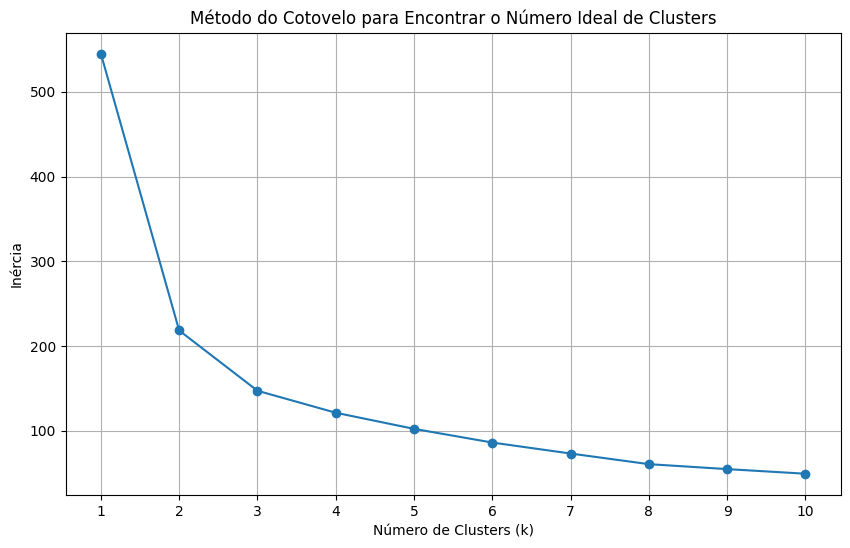

In [6]:
# --- 3. MÉTODO DO COTOVELO ---
inercia = []
range_clusters = range(1, 11)  # Vamos testar de 1 a 10 clusters

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(dados_escalonados)
    inercia.append(kmeans.inertia_)

# Plotando o gráfico do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(range_clusters, inercia, marker="o")
plt.title("Método do Cotovelo para Encontrar o Número Ideal de Clusters")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inércia")
plt.xticks(range_clusters)
plt.grid(True)
plt.show()

In [7]:
# --- 4. RODANDO O MODELO FINAL ---
# Supondo que o número ideal de clusters que encontramos foi 3
numero_ideal_clusters = 3

kmeans_final = KMeans(n_clusters=numero_ideal_clusters, random_state=42, n_init=10)
kmeans_final.fit(dados_escalonados)

# Adicionando os rótulos dos clusters de volta ao nosso DataFrame
df_cluster["cluster"] = kmeans_final.labels_


# --- 5. INTERPRETAÇÃO DOS CLUSTERS (PROFILING) ---
# Este é o passo mais importante: entender o que cada cluster significa.
# Vamos agrupar por cluster e calcular a média de cada variável.
perfis_clusters = df_cluster.groupby("cluster").mean().round(2)

print("--- Perfis dos Clusters Encontrados ---")
print(perfis_clusters)

--- Perfis dos Clusters Encontrados ---
         Tempo_Final_seg  diff_relativa_segunda_primeira_parte  Variabilidade_Ritmo_std  Ritmo_Medio_SUBIDA  Ritmo_Medio_DESCIDA
cluster                                                                                                                         
0               36414.87                                 -0.15                   729.28             1284.11               821.48
1               27812.03                                 -0.07                   473.29              962.87               647.21
2               19575.72                                 -0.22                   270.22              655.64               469.38


In [8]:
# --- 4. RODANDO O MODELO FINAL ---
# Supondo que o número ideal de clusters que encontramos foi 3
numero_ideal_clusters = 4

kmeans_final = KMeans(n_clusters=numero_ideal_clusters, random_state=42, n_init=10)
kmeans_final.fit(dados_escalonados)

# Adicionando os rótulos dos clusters de volta ao nosso DataFrame
df_cluster["cluster"] = kmeans_final.labels_


# --- 5. INTERPRETAÇÃO DOS CLUSTERS (PROFILING) ---
# Este é o passo mais importante: entender o que cada cluster significa.
# Vamos agrupar por cluster e calcular a média de cada variável.
perfis_clusters = df_cluster.groupby("cluster").mean().round(2)

print("--- Perfis dos Clusters Encontrados ---")
print(perfis_clusters)

--- Perfis dos Clusters Encontrados ---
         Tempo_Final_seg  diff_relativa_segunda_primeira_parte  Variabilidade_Ritmo_std  Ritmo_Medio_SUBIDA  Ritmo_Medio_DESCIDA
cluster                                                                                                                         
0               30920.55                                 -0.12                   560.84             1089.09               696.86
1               23152.81                                 -0.08                   359.93              782.43               562.58
2               19138.27                                 -0.25                   259.42              640.91               455.15
3               37460.33                                 -0.15                   752.88             1317.87               848.04
